# Comparative Study of Graph Neural Networks for Intrusion Detection on the UNSW-NB15 Dataset

In [8]:
#!/usr/bin/env python3
import nbformat

# 1. Load your notebook as v4 (keeps outputs intact)
nb = nbformat.read('Comparative Study of GNN for UNSW-NB15.ipynb', as_version=4)

# 2. Remove only the 'widgets' entries—leave everything else (including outputs) untouched
nb.metadata.pop('widgets', None)
for cell in nb.cells:
    cell.metadata.pop('widgets', None)

# 3. Write out a new cleaned notebook
nbformat.write(nb, 'Comparative Study of GNN for UNSW-NB15-fixed2.ipynb')


In [7]:
#!/usr/bin/env python3
import nbformat
from nbformat.validator import validate, ValidationError

# 1. Load and convert to v4
nb = nbformat.read('Comparative Study of GNN for UNSW-NB15.ipynb', as_version=4)

# 2. Drop any widget specs
nb.metadata.pop('widgets', None)
for cell in nb.cells:
    cell.metadata.pop('widgets', None)
    cell['execution_count'] = None
    cell['outputs'] = []

# 3. (Optional) catch any remaining validation errors
try:
    validate(nb)
except ValidationError as e:
    print("Validation error (you can still write file):", e)

# 4. Write out
nbformat.write(nb, 'Comparative Study of GNN for UNSW-NB15-fixed.ipynb')


Validation error (you can still write file): Additional properties are not allowed ('execution_count', 'outputs' were unexpected)

Failed validating 'additionalProperties' in markdown_cell:

On instance['cells'][0]:
{'cell_type': 'markdown',
 'execution_count': None,
 'metadata': {'id': 'EnF2FB5gEjGu'},
 'outputs': ['...0 outputs...'],
 'source': '# Comparative Study of Graph Neural Networks for Intrusion '
           'Detec...'}


## Pre-requisites

## Installing torch_geometric as a pre-requisite

In [1]:
!pip install torch_geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.8 MB/s eta 0:00:00


## Importing pre-requisites

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, auc


## Loading the data and encoding categorical features after combining the dataset

In [11]:
# Load data
train_df = pd.read_csv('UNSW_NB15_training-set.csv')
test_df = pd.read_csv('UNSW_NB15_testing-set.csv')
combined_df = pd.concat([train_df, test_df])

# Encode categorical features
label_encoders = {}
for col in ['proto', 'service', 'state', 'attack_cat']:
    le = LabelEncoder()
    combined_df[col] = le.fit_transform(combined_df[col])
    label_encoders[col] = le

## Splitting the dataset back to train_df and test_df and defining the features

In [12]:
# Split back into train and test sets
train_df_encoded = combined_df.iloc[:len(train_df)]
test_df_encoded = combined_df.iloc[len(train_df):]

# Define features and labels
features = [
    'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes',
    'rate', 'sttl', 'dttl', 'swin', 'dwin', 'trans_depth', 'sjit', 'djit',
    'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl',
    'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src',
    'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm',
    'ct_dst_sport_ltm', 'ct_dst_src_ltm'
]

## Visualizing the feature distribution and the correlation matrix for the features before processing, regularising and oversampling

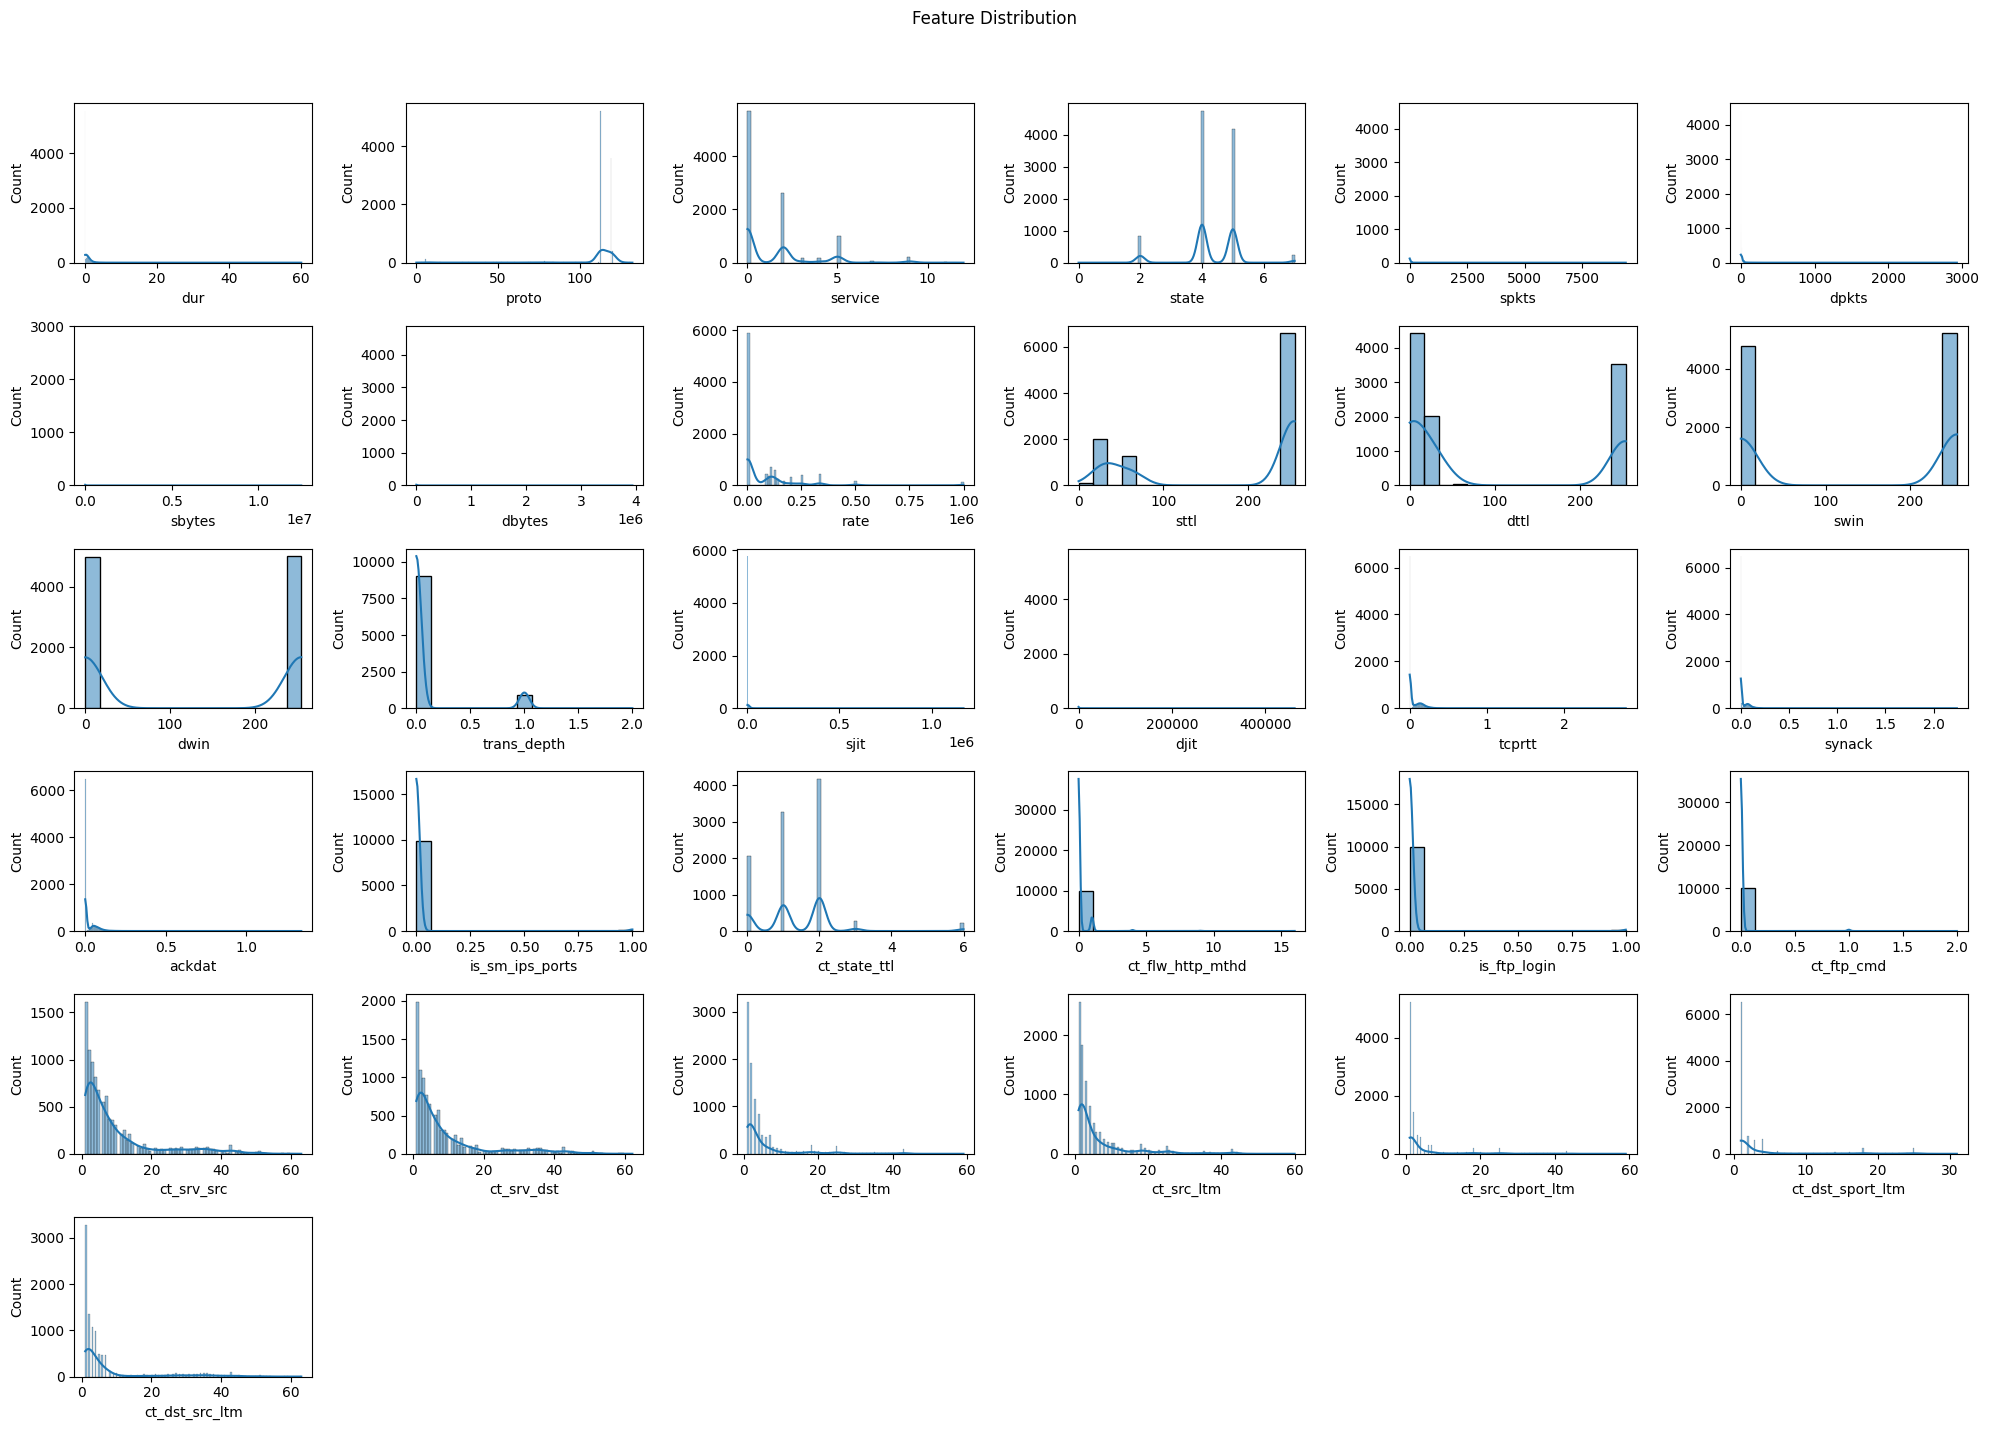

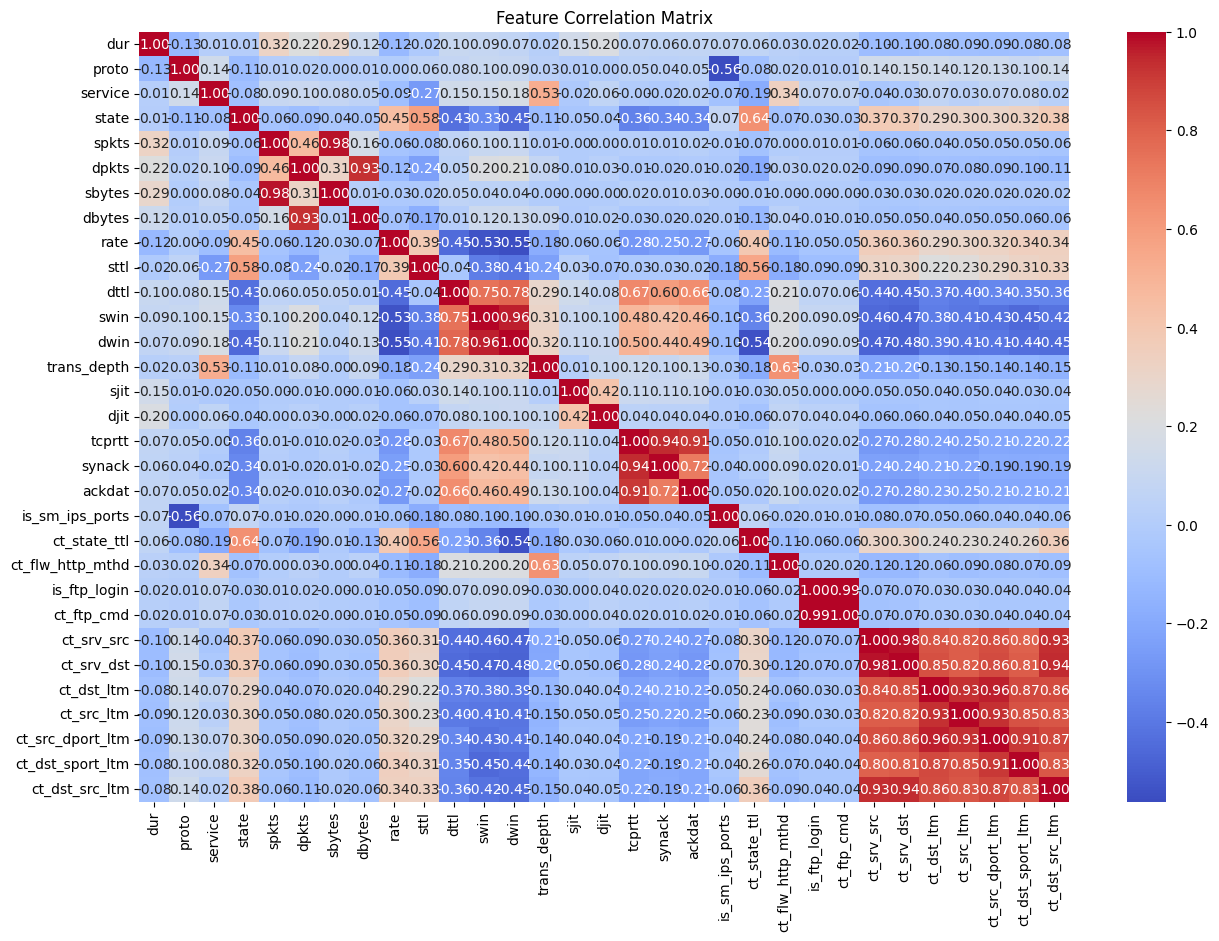

In [13]:
# Reduce sample size if the dataset is large
sampled_df = train_df_encoded.sample(n=10000, random_state=42) if len(train_df_encoded) > 10000 else train_df_encoded

# Determine the number of rows and columns for subplots
num_features = len(features)
num_cols = 6
num_rows = (num_features + num_cols - 1) // num_cols  # This ensures we have enough rows

# Display data distribution for each feature
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 15))
fig.suptitle('Feature Distribution')

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(sampled_df[feature], kde=True, ax=axes[i])

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Display correlation matrix
corr_matrix = sampled_df[features].corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

## Defining features, label and using a standardize scaler to standardize the features and oversampling the minority class

In [14]:
X_train = train_df_encoded[features]
X_test = test_df_encoded[features]
y_train = train_df_encoded['label']
y_test = test_df_encoded['label']

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

## Visualizing the feature distribution and the correlation matrix for the features after processing, regularising and oversampling

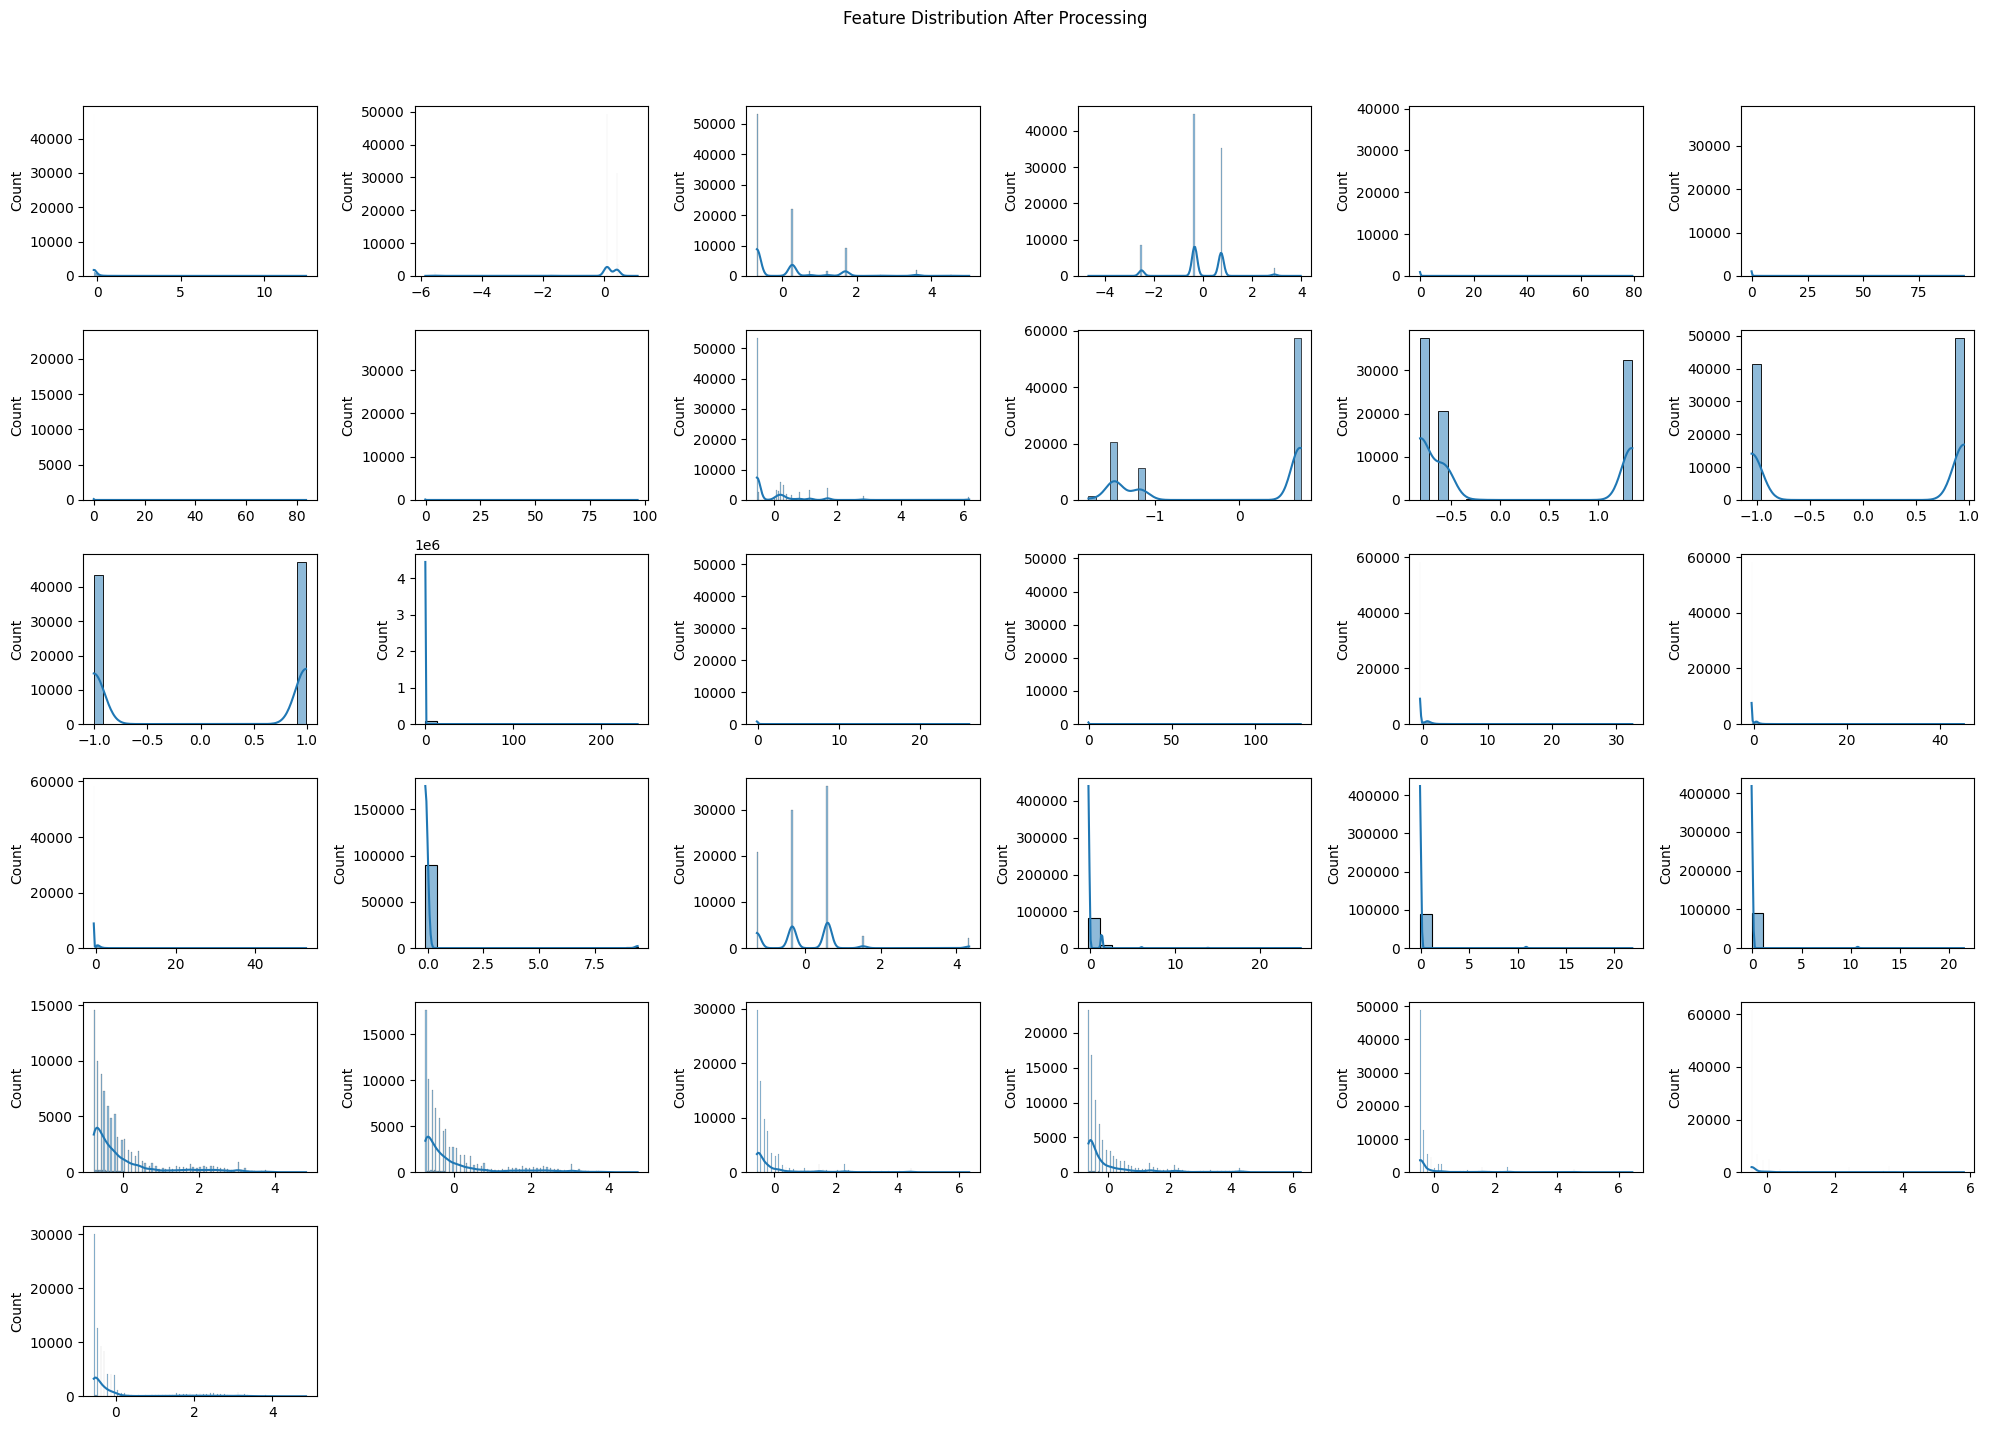

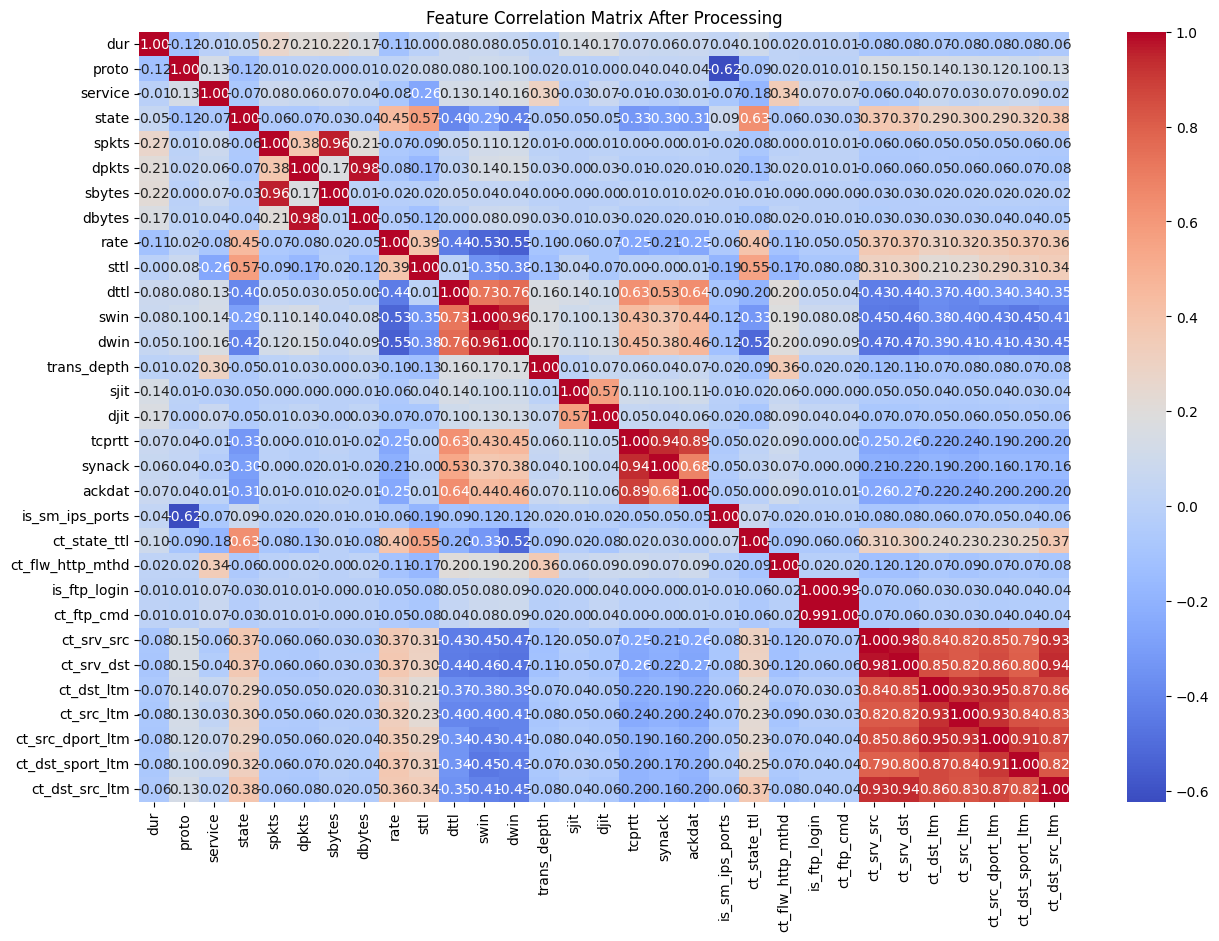

In [16]:
# Data distribution after scaling and SMOTE
num_features = len(features)
num_cols = 6
num_rows = (num_features + num_cols - 1) // num_cols  # Ensures enough rows

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 15))
fig.suptitle('Feature Distribution After Processing')

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(X_train_resampled[:, i], kde=True, ax=axes[i])

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Display correlation matrix after scaling
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=features)
corr_matrix = X_train_resampled_df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix After Processing')
plt.show()

## Creating tensors

In [20]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

## K-Nearest Neighbors graph creation

In [21]:
from sklearn.neighbors import NearestNeighbors

def create_knn_edge_index(data, k=5):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)
    row, col = [], []
    for i in range(indices.shape[0]):
        for j in range(1, k):  # Start from 1 to avoid self-loop
            row.append(i)
            col.append(indices[i, j])
    edge_index = torch.tensor([row, col], dtype=torch.long)
    return edge_index

def create_data_loader(X_tensor, y_tensor, batch_size=1024, k=5):
    data_list = []
    num_batches = len(X_tensor) // batch_size + (1 if len(X_tensor) % batch_size != 0 else 0)
    for i in range(num_batches):
        start_idx, end_idx = i * batch_size, min((i + 1) * batch_size, len(X_tensor))
        X_batch, y_batch = X_tensor[start_idx:end_idx], y_tensor[start_idx:end_idx]
        edge_index_batch = create_knn_edge_index(X_batch.numpy(), k=k)
        data = Data(x=X_batch, edge_index=edge_index_batch, y=y_batch)
        data_list.append(data)
    return DataLoader(data_list, batch_size=1, shuffle=True)

train_loader = create_data_loader(X_train_tensor, y_train_tensor, batch_size=1024, k=5)
test_loader = create_data_loader(X_test_tensor, y_test_tensor, batch_size=1024, k=5)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Creating a base GAT model that we will further improve

In [23]:
class CyberSecurityGATGridSearch(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1, dropout=0.0):
        super(CyberSecurityGATGridSearch, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout)
        self.lin = nn.Linear(hidden_channels * heads, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return x

## Training and evaluating the model using different hidden channel sizes, heads, dropout values, learning rate to find the best model parameters

In [ ]:
def train_and_evaluate(params):
    model = CyberSecurityGATGridSearch(
        in_channels=X_train_tensor.size(1),
        hidden_channels=params['hidden_channels'],
        out_channels=2,
        heads=params['heads'],
        dropout=params['dropout']
    )
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = nn.CrossEntropyLoss()

    for epoch in range(params['num_epochs']):
        model.train()
        running_loss = 0.0
        for data in train_loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{params['num_epochs']}], Loss: {running_loss/len(train_loader):.4f}")

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data in test_loader:
            out = model(data.x, data.edge_index)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.y.size(0)
    accuracy = correct / total
    return accuracy

param_grid = {
    'hidden_channels': [32, 64, 128],
    'heads': [1, 4, 8],
    'dropout': [0.0, 0.3, 0.5],
    'learning_rate': [0.001, 0.0001],
    'num_epochs': [100]
}

best_accuracy = 0
best_params = None
for hidden_channels in param_grid['hidden_channels']:
    for heads in param_grid['heads']:
        for dropout in param_grid['dropout']:
            for learning_rate in param_grid['learning_rate']:
                for num_epochs in param_grid['num_epochs']:
                    params = {
                        'hidden_channels': hidden_channels,
                        'heads': heads,
                        'dropout': dropout,
                        'learning_rate': learning_rate,
                        'num_epochs': num_epochs
                    }
                    print(f"Training with params: {params}")
                    accuracy = train_and_evaluate(params)
                    print(f"Accuracy: {accuracy:.4f}")
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_params = params

print("Best Accuracy: ", best_accuracy)
print("Best Params: ", best_params)


## Adding all the obtained accuracies based on parameters to create a table

In [18]:
import pandas as pd

# List of dictionaries containing the parameter sets and their corresponding accuracies
data = [
    {'hidden_channels': 32, 'heads': 1, 'dropout': 0.5, 'learning_rate': 0.0001, 'num_s': 100, 'accuracy': 0.8776},
    {'hidden_channels': 32, 'heads': 4, 'dropout': 0.0, 'learning_rate': 0.001, 'num_s': 100, 'accuracy': 0.8703},
    {'hidden_channels': 32, 'heads': 4, 'dropout': 0.0, 'learning_rate': 0.0001, 'num_s': 100, 'accuracy': 0.8722},
    {'hidden_channels': 32, 'heads': 4, 'dropout': 0.3, 'learning_rate': 0.001, 'num_s': 100, 'accuracy': 0.8690},
    {'hidden_channels': 32, 'heads': 4, 'dropout': 0.3, 'learning_rate': 0.0001, 'num_s': 100, 'accuracy': 0.8704},
    {'hidden_channels': 32, 'heads': 4, 'dropout': 0.5, 'learning_rate': 0.001, 'num_s': 100, 'accuracy': 0.8378},
    {'hidden_channels': 32, 'heads': 4, 'dropout': 0.5, 'learning_rate': 0.0001, 'num_s': 100, 'accuracy': 0.8382},
    {'hidden_channels': 32, 'heads': 8, 'dropout': 0.0, 'learning_rate': 0.001, 'num_s': 100, 'accuracy': 0.8638},
    {'hidden_channels': 32, 'heads': 8, 'dropout': 0.0, 'learning_rate': 0.0001, 'num_s': 100, 'accuracy': 0.8465},
    {'hidden_channels': 32, 'heads': 8, 'dropout': 0.3, 'learning_rate': 0.001, 'num_s': 100, 'accuracy': 0.8230},
    {'hidden_channels': 32, 'heads': 8, 'dropout': 0.3, 'learning_rate': 0.0001, 'num_s': 100, 'accuracy': 0.8519},
    {'hidden_channels': 32, 'heads': 8, 'dropout': 0.5, 'learning_rate': 0.001, 'num_s': 100, 'accuracy': 0.8469},
    {'hidden_channels': 32, 'heads': 8, 'dropout': 0.5, 'learning_rate': 0.0001, 'num_s': 100, 'accuracy': 0.8663},
    {'hidden_channels': 64, 'heads': 1, 'dropout': 0.0, 'learning_rate': 0.001, 'num_s': 100, 'accuracy': 0.8495},
    {'hidden_channels': 64, 'heads': 1, 'dropout': 0.0, 'learning_rate': 0.0001, 'num_s': 100, 'accuracy': 0.8483},
    {'hidden_channels': 64, 'heads': 1, 'dropout': 0.3, 'learning_rate': 0.001, 'num_s': 100, 'accuracy': 0.7952},
    {'hidden_channels': 64, 'heads': 1, 'dropout': 0.3, 'learning_rate': 0.0001, 'num_s': 100, 'accuracy': 0.8709},
    {'hidden_channels': 64, 'heads': 1, 'dropout': 0.5, 'learning_rate': 0.001, 'num_s': 100, 'accuracy': 0.8216},
    {'hidden_channels': 64, 'heads': 1, 'dropout': 0.5, 'learning_rate': 0.0001, 'num_s': 100, 'accuracy': 0.8676},
    {'hidden_channels': 64, 'heads': 4, 'dropout': 0.0, 'learning_rate': 0.001, 'num_s': 100, 'accuracy': 0.8513},
    {'hidden_channels': 64, 'heads': 4, 'dropout': 0.0, 'learning_rate': 0.0001, 'num_s': 100, 'accuracy': 0.8307},
    {'hidden_channels': 64, 'heads': 4, 'dropout': 0.3, 'learning_rate': 0.001, 'num_s': 100, 'accuracy': 0.8490},
    {'hidden_channels': 64, 'heads': 4, 'dropout': 0.3, 'learning_rate': 0.0001, 'num_s': 100, 'accuracy': 0.8672},
    {'hidden_channels': 64, 'heads': 4, 'dropout': 0.5, 'learning_rate': 0.001, 'num_s': 100, 'accuracy': 0.8275},
    {'hidden_channels': 64, 'heads': 4, 'dropout': 0.5, 'learning_rate': 0.0001, 'num_s': 100, 'accuracy': 0.8547},
    {'hidden_channels': 64, 'heads': 8, 'dropout': 0.0, 'learning_rate': 0.001, 'num_s': 100, 'accuracy': 0.8680},
    {'hidden_channels': 64, 'heads': 8, 'dropout': 0.0, 'learning_rate': 0.0001, 'num_s': 100, 'accuracy': 0.8685},
    {'hidden_channels': 64, 'heads': 8, 'dropout': 0.3, 'learning_rate': 0.001, 'num_s': 100, 'accuracy': 0.9030},
    {'hidden_channels': 64, 'heads': 8, 'dropout': 0.3, 'learning_rate': 0.0001, 'num_s': 100, 'accuracy': 0.8715},
    {'hidden_channels': 64, 'heads': 8, 'dropout': 0.5, 'learning_rate': 0.001, 'num_s': 100, 'accuracy': 0.8098},
    {'hidden_channels': 64, 'heads': 8, 'dropout': 0.5, 'learning_rate': 0.0001, 'num_s': 100, 'accuracy': 0.8613},
    {'hidden_channels': 128, 'heads': 1, 'dropout': 0.0, 'learning_rate': 0.001, 'num_s': 100, 'accuracy': 0.8443},
    {'hidden_channels': 128, 'heads': 1, 'dropout': 0.0, 'learning_rate': 0.0001, 'num_s': 100, 'accuracy': 0.8644},
    {'hidden_channels': 128, 'heads': 1, 'dropout': 0.3, 'learning_rate': 0.001, 'num_s': 100, 'accuracy': 0.8603},
    {'hidden_channels': 128, 'heads': 1, 'dropout': 0.3, 'learning_rate': 0.0001, 'num_s': 100, 'accuracy': 0.8924},
    {'hidden_channels': 128, 'heads': 1, 'dropout': 0.5, 'learning_rate': 0.001, 'num_s': 100, 'accuracy': 0.9027},
    {'hidden_channels': 128, 'heads': 1, 'dropout': 0.5, 'learning_rate': 0.0001, 'num_s': 100, 'accuracy': 0.8686},
    {'hidden_channels': 128, 'heads': 4, 'dropout': 0.0, 'learning_rate': 0.001, 'num_s': 100, 'accuracy': 0.8400},
    {'hidden_channels': 128, 'heads': 4, 'dropout': 0.0, 'learning_rate': 0.0001, 'num_s': 100, 'accuracy': 0.8624},
    {'hidden_channels': 128, 'heads': 4, 'dropout': 0.3, 'learning_rate': 0.001, 'num_s': 100, 'accuracy': 0.8383},
    {'hidden_channels': 128, 'heads': 4, 'dropout': 0.3, 'learning_rate': 0.0001, 'num_s': 100, 'accuracy': 0.8306},
    {'hidden_channels': 128, 'heads': 4, 'dropout': 0.5, 'learning_rate': 0.001, 'num_s': 100, 'accuracy': 0.8499},
    {'hidden_channels': 128, 'heads': 4, 'dropout': 0.5, 'learning_rate': 0.0001, 'num_s': 100, 'accuracy': 0.8589},
    {'hidden_channels': 128, 'heads': 8, 'dropout': 0.0, 'learning_rate': 0.001, 'num_s': 100, 'accuracy': 0.8754},
    {'hidden_channels': 128, 'heads': 8, 'dropout': 0.0, 'learning_rate': 0.0001, 'num_s': 100, 'accuracy': 0.8693},
    {'hidden_channels': 128, 'heads': 8, 'dropout': 0.3, 'learning_rate': 0.001, 'num_s': 100, 'accuracy': 0.8580},
    {'hidden_channels': 128, 'heads': 8, 'dropout': 0.3, 'learning_rate': 0.0001, 'num_s': 100, 'accuracy': 0.8714},
    {'hidden_channels': 128, 'heads': 8, 'dropout': 0.5, 'learning_rate': 0.001, 'num_s': 100, 'accuracy': 0.8121},
    {'hidden_channels': 128, 'heads': 8, 'dropout': 0.5, 'learning_rate': 0.0001, 'num_s': 100, 'accuracy': 0.8391}
]

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data)

# Display the table
print(df)


    hidden_channels  heads  dropout  learning_rate  num_s  accuracy
0                32      1      0.5         0.0001    100    0.8776
1                32      4      0.0         0.0010    100    0.8703
2                32      4      0.0         0.0001    100    0.8722
3                32      4      0.3         0.0010    100    0.8690
4                32      4      0.3         0.0001    100    0.8704
5                32      4      0.5         0.0010    100    0.8378
6                32      4      0.5         0.0001    100    0.8382
7                32      8      0.0         0.0010    100    0.8638
8                32      8      0.0         0.0001    100    0.8465
9                32      8      0.3         0.0010    100    0.8230
10               32      8      0.3         0.0001    100    0.8519
11               32      8      0.5         0.0010    100    0.8469
12               32      8      0.5         0.0001    100    0.8663
13               64      1      0.0         0.00

#Training the model with the best parameters for 200 epochs

In [ ]:
best_params = {'hidden_channels': 64, 'heads': 8, 'dropout': 0.3, 'learning_rate': 0.001, 'num_s': 200}

best_model = CyberSecurityGATGridSearch(
    in_channels=X_train_tensor.size(1),
    hidden_channels=best_params['hidden_channels'],
    out_channels=2,
    heads=best_params['heads'],
    dropout=best_params['dropout']
)
optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
criterion = nn.CrossEntropyLoss()

for epoch in range(100):
    best_model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        out = best_model(data.x, data.edge_index)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/100], Loss: {running_loss/len(train_loader):.4f}")

best_model.eval()
correct, total = 0, 0
y_true, y_pred = [], []
with torch.no_grad():
    for data in test_loader:
        out = best_model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total += data.y.size(0)
        y_true.extend(data.y.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())
accuracy = correct / total
print('Final Accuracy:', accuracy)

print("Classification Report:")
print(classification_report(y_true, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

### Plotting a Precision-Recall Curve for the model

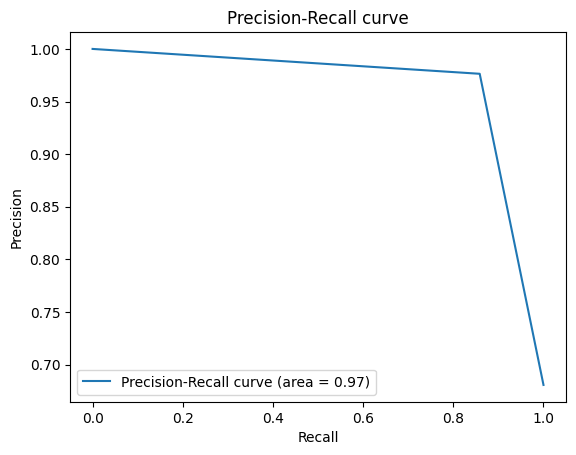

In [62]:
# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)
pr_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve (area = {:.2f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()

### Plotting the confusion matrix

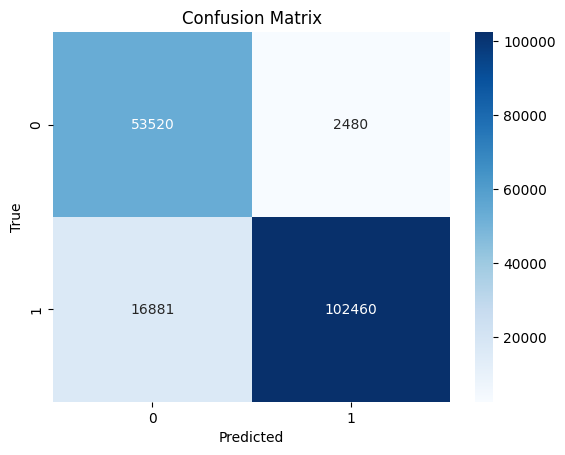

In [63]:
# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Exploring other models to understand how well our model works

### Creating an MLP model

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Training the MLP model

In [ ]:
mlp_model = MLP(input_dim=X_train_tensor.size(1), hidden_dim=64, output_dim=2)
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
mlp_criterion = nn.CrossEntropyLoss()

# Training loop for MLP model
for epoch in range(100):
    mlp_model.train()
    running_loss = 0.0
    for data in train_loader:
        mlp_optimizer.zero_grad()
        out = mlp_model(data.x)
        loss = mlp_criterion(out, data.y)
        loss.backward()
        mlp_optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/100], Loss: {running_loss/len(train_loader):.4f}")

# Evaluation for MLP model
mlp_model.eval()
correct, total = 0, 0
mlp_y_true, mlp_y_pred = [], []
with torch.no_grad():
    for data in test_loader:
        out = mlp_model(data.x)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total += data.y.size(0)
        mlp_y_true.extend(data.y.cpu().numpy())
        mlp_y_pred.extend(pred.cpu().numpy())
mlp_accuracy = correct / total
print('MLP Final Accuracy:', mlp_accuracy)


## Creating a GCN Model

In [ ]:
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return x


### Training the created GCN Model

In [ ]:
gcn_model = GCN(in_channels=X_train_tensor.size(1), hidden_channels=64, out_channels=2)
gcn_optimizer = optim.Adam(gcn_model.parameters(), lr=0.001)
gcn_criterion = nn.CrossEntropyLoss()

# Training loop for GCN model
for epoch in range(100):
    gcn_model.train()
    running_loss = 0.0
    for data in train_loader:
        gcn_optimizer.zero_grad()
        out = gcn_model(data.x, data.edge_index)
        loss = gcn_criterion(out, data.y)
        loss.backward()
        gcn_optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/100], Loss: {running_loss/len(train_loader):.4f}")

# Evaluation for GCN model
gcn_model.eval()
correct, total = 0, 0
gcn_y_true, gcn_y_pred = [], []
with torch.no_grad():
    for data in test_loader:
        out = gcn_model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total += data.y.size(0)
        gcn_y_true.extend(data.y.cpu().numpy())
        gcn_y_pred.extend(pred.cpu().numpy())
gcn_accuracy = correct / total
print('GCN Final Accuracy:', gcn_accuracy)


## Comparison of all three models to determine which one performs better

MLP Final Accuracy: 0.8517289167964138
GCN Final Accuracy: 0.8754883341602934
GAT Final Accuracy: 0.8524646260714835
MLP Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.98      0.81     56000
           1       0.99      0.79      0.88    119341

    accuracy                           0.85    175341
   macro avg       0.84      0.89      0.84    175341
weighted avg       0.89      0.85      0.86    175341

GCN Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.97      0.83     56000
           1       0.98      0.83      0.90    119341

    accuracy                           0.88    175341
   macro avg       0.86      0.90      0.87    175341
weighted avg       0.90      0.88      0.88    175341

GAT Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.97      0.81     56000
           1       0.98      0.80      

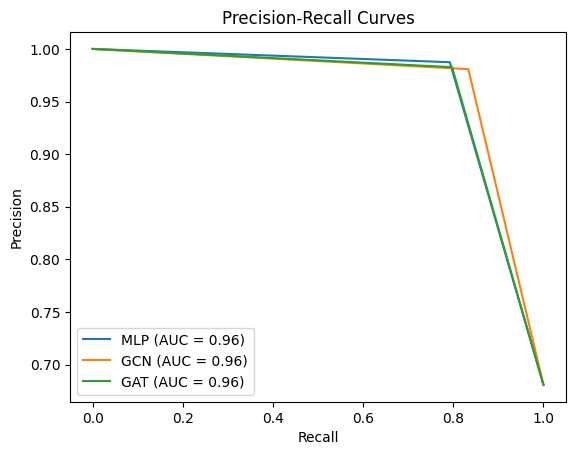

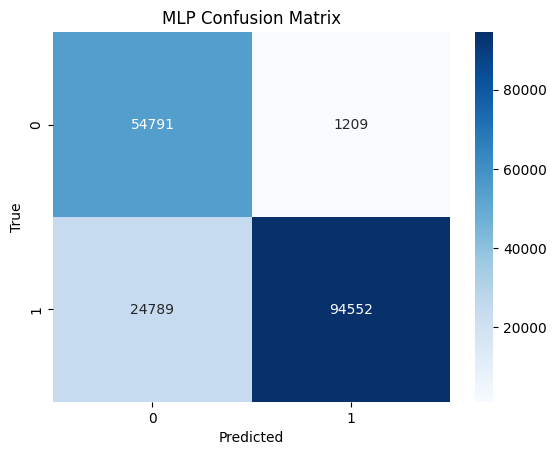

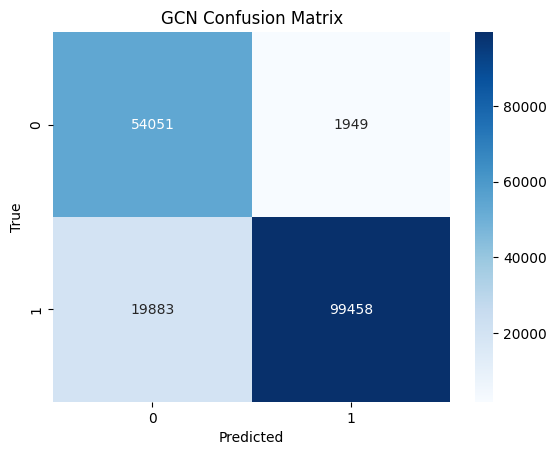

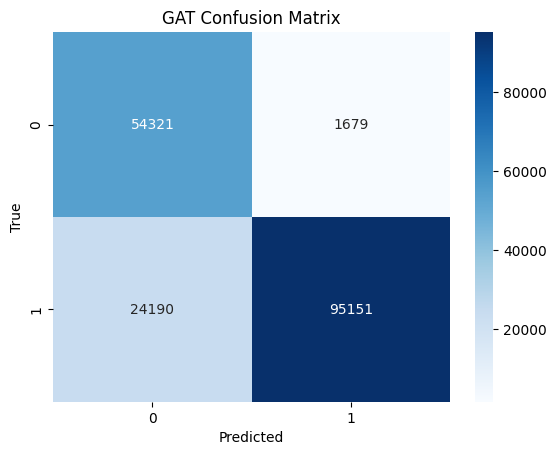

In [45]:
# Compare the models
print(f"MLP Final Accuracy: {mlp_accuracy}")
print(f"GCN Final Accuracy: {gcn_accuracy}")
print(f"GAT Final Accuracy: {accuracy}")

# Print Classification Reports
print("MLP Classification Report:")
print(classification_report(mlp_y_true, mlp_y_pred))

print("GCN Classification Report:")
print(classification_report(gcn_y_true, gcn_y_pred))

print("GAT Classification Report:")
print(classification_report(y_true, y_pred))

# Print Confusion Matrices
print("MLP Confusion Matrix:")
print(confusion_matrix(mlp_y_true, mlp_y_pred))

print("GCN Confusion Matrix:")
print(confusion_matrix(gcn_y_true, gcn_y_pred))

print("GAT Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Plot Precision-Recall Curves
def plot_precision_recall_curve(y_true, y_pred, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.2f})')

plt.figure()
plot_precision_recall_curve(mlp_y_true, mlp_y_pred, 'MLP')
plot_precision_recall_curve(gcn_y_true, gcn_y_pred, 'GCN')
plot_precision_recall_curve(y_true, y_pred, 'GAT')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left")
plt.show()

# Plot Confusion Matrices
def plot_confusion_matrix(cm, model_name):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

plot_confusion_matrix(confusion_matrix(mlp_y_true, mlp_y_pred), 'MLP')
plot_confusion_matrix(confusion_matrix(gcn_y_true, gcn_y_pred), 'GCN')
plot_confusion_matrix(confusion_matrix(y_true, y_pred), 'GAT')


### Results:



1.   MLP Final Accuracy: 0.8517289167964138
2.   GCN Final Accuracy: 0.8754883341602934
3.   GAT Final Accuracy: 0.8524646260714835

From this we infer that GAT does perform better than the MLP model but not better than the GCN model, we perform further analysis to create a more advanced GAT model





## Creating an advanced GAT model

In [49]:
from torch_geometric.nn import GATConv, LayerNorm

class AdvancedGAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1, dropout=0.0):
        super(AdvancedGAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.norm1 = LayerNorm(hidden_channels * heads)
        self.lin1 = nn.Linear(in_channels, hidden_channels * heads)  # Linear layer for residual connection
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout)
        self.norm2 = LayerNorm(hidden_channels * heads)
        self.lin2 = nn.Linear(hidden_channels * heads, hidden_channels * heads)  # Linear layer for residual connection
        self.fc = nn.Linear(hidden_channels * heads, out_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        residual = self.lin1(x)
        x = self.conv1(x, edge_index)
        x = F.relu(self.norm1(x))
        x = self.dropout(x)
        x += residual  # Add residual connection

        residual = self.lin2(x)
        x = self.conv2(x, edge_index)
        x = F.relu(self.norm2(x))
        x = self.dropout(x)
        x += residual  # Add residual connection

        x = self.fc(x)
        return x

### Setting the best parameters obtained earlier and declaring the optimizer and the criterion function

In [50]:
# Instantiate the advanced GAT model
best_params = {'hidden_channels': 128, 'heads': 8, 'dropout': 0.3, 'learning_rate': 0.0001, 'num_epochs': 100}
advanced_gat_model = AdvancedGAT(
    in_channels=X_train_tensor.size(1),
    hidden_channels=best_params['hidden_channels'],
    out_channels=2,
    heads=best_params['heads'],
    dropout=best_params['dropout']
)

optimizer = optim.Adam(advanced_gat_model.parameters(), lr=best_params['learning_rate'])
criterion = nn.CrossEntropyLoss()

### Training the Advanced GAT for 100 epochs, evaluating the same and giving the final accuracy, classification report and the confusion matrix for the model

In [ ]:
# Training Loop
for epoch in range(best_params['num_epochs']):
    advanced_gat_model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        out = advanced_gat_model(data.x, data.edge_index)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{best_params['num_epochs']}], Loss: {running_loss/len(train_loader):.4f}")

# Evaluation Loop
advanced_gat_model.eval()
correct, total = 0, 0
agat_y_true, agat_y_pred = [], []
with torch.no_grad():
    for data in test_loader:
        out = advanced_gat_model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total += data.y.size(0)
        agat_y_true.extend(data.y.cpu().numpy())
        agat_y_pred.extend(pred.cpu().numpy())
agat_accuracy = correct / total
print('Advanced GAT Final Accuracy:', agat_accuracy)

print("Classification Report:")
print(classification_report(agat_y_true, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(agat_y_true, y_pred)
print(cm)

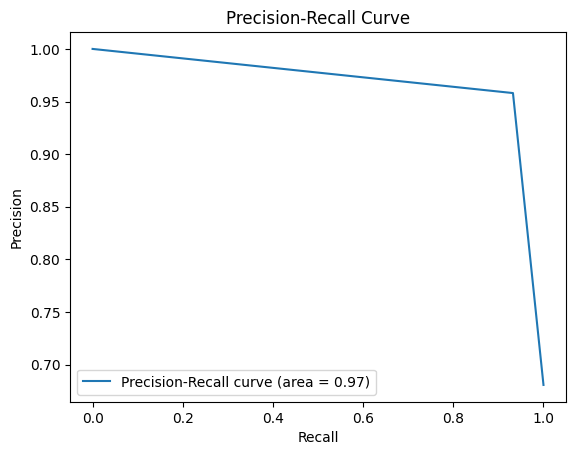

In [55]:

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(agat_y_true, agat_y_pred)
pr_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve (area = {:.2f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


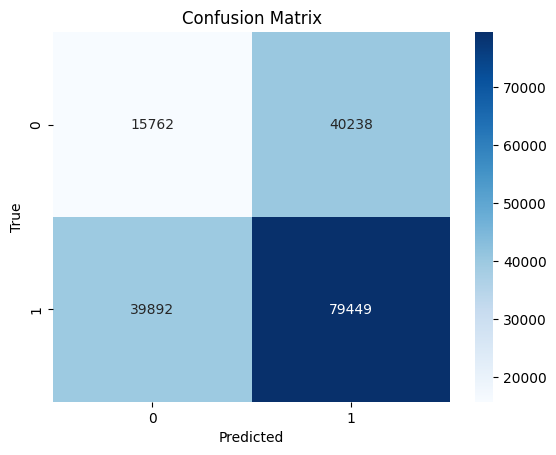

In [56]:
# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Ablation Studies:

##Advanced GAT model without Residual Connections

### Creating the model

In [77]:
# Define the Advanced GAT model without Residual Connections
class AdvancedGATNoResidual(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1, dropout=0.0):
        super(AdvancedGATNoResidual, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.norm1 = LayerNorm(hidden_channels * heads)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout)
        self.norm2 = LayerNorm(hidden_channels * heads)
        self.fc = nn.Linear(hidden_channels * heads, out_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(self.norm1(x))
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = F.relu(self.norm2(x))
        x = self.dropout(x)

        x = self.fc(x)
        return x


### Setting best parameters found previously

In [78]:
# Instantiate the ablated models
advanced_gat_no_residual = AdvancedGATNoResidual(
    in_channels=X_train_tensor.size(1),
    hidden_channels=128,
    out_channels=2,
    heads=8,
    dropout=0.3
)

### Training the model

In [ ]:
advanced_gat_no_residual_accuracy, advanced_gat_no_residual_y_true, advanced_gat_no_residual_y_pred, advanced_gat_no_residual_losses = train_and_evaluate(advanced_gat_no_residual, train_loader, test_loader)


## Advanced GAT model without Normalization Layers

In [80]:
# Define the Advanced GAT model without Layer Normalization
class AdvancedGATNoLayerNorm(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1, dropout=0.0):
        super(AdvancedGATNoLayerNorm, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.lin1 = nn.Linear(in_channels, hidden_channels * heads)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout)
        self.lin2 = nn.Linear(hidden_channels * heads, hidden_channels * heads)
        self.fc = nn.Linear(hidden_channels * heads, out_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        residual = self.lin1(x)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x += residual

        residual = self.lin2(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x += residual

        x = self.fc(x)
        return x

### Setting best parameters found previously

In [81]:
advanced_gat_no_layer_norm = AdvancedGATNoLayerNorm(
    in_channels=X_train_tensor.size(1),
    hidden_channels=128,
    out_channels=2,
    heads=8,
    dropout=0.3
)

### Training the model

In [ ]:
advanced_gat_no_layer_norm_accuracy, advanced_gat_no_layer_norm_y_true, advanced_gat_no_layer_norm_y_pred, advanced_gat_no_layer_norm_losses = train_and_evaluate(advanced_gat_no_layer_norm, train_loader, test_loader)


## Comparison between the two models

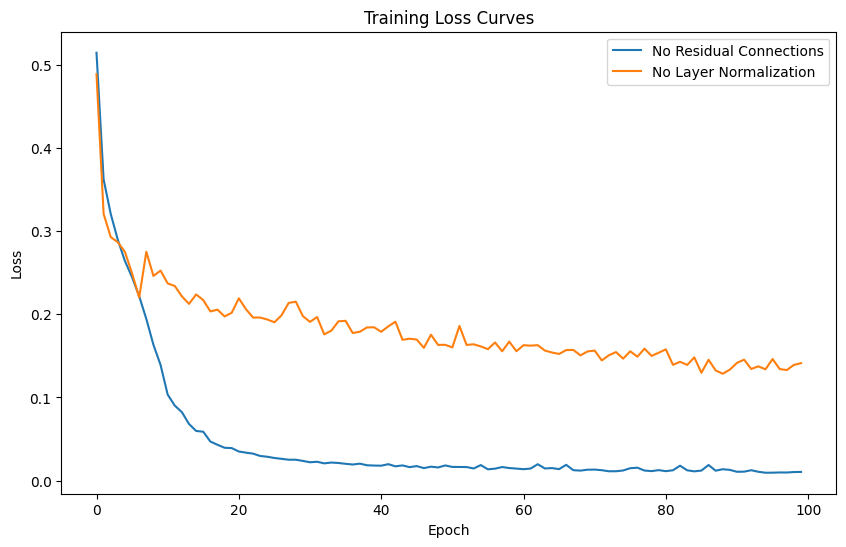

No Residual Connections Accuracy: 0.9206574617459693
No Layer Normalization Accuracy: 0.8520939198476112
No Residual Connections Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88     56000
           1       0.96      0.92      0.94    119341

    accuracy                           0.92    175341
   macro avg       0.90      0.92      0.91    175341
weighted avg       0.92      0.92      0.92    175341

No Layer Normalization Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.97      0.81     56000
           1       0.98      0.80      0.88    119341

    accuracy                           0.85    175341
   macro avg       0.84      0.88      0.84    175341
weighted avg       0.89      0.85      0.86    175341



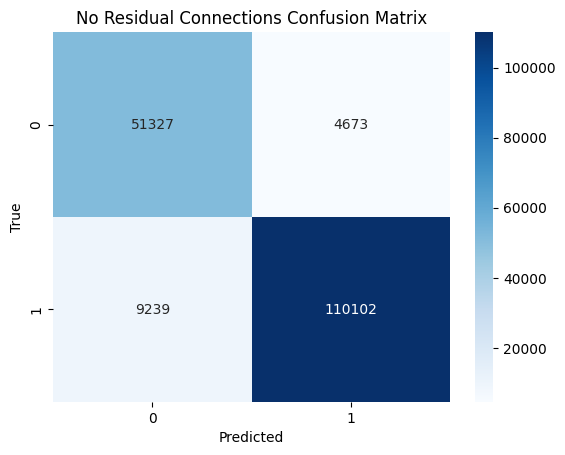

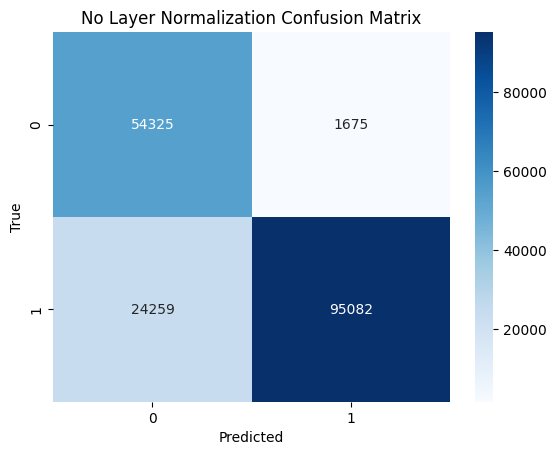

Advanced GAT No Residual Connections Accuracy: 0.9207
Advanced GAT No Layer Normalization Accuracy: 0.8521


In [83]:
# Plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(advanced_gat_no_residual_losses, label='No Residual Connections')
plt.plot(advanced_gat_no_layer_norm_losses, label='No Layer Normalization')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.show()

# Print results
print(f"No Residual Connections Accuracy: {advanced_gat_no_residual_accuracy}")
print(f"No Layer Normalization Accuracy: {advanced_gat_no_layer_norm_accuracy}")

print("No Residual Connections Classification Report:")
print(classification_report(advanced_gat_no_residual_y_true, advanced_gat_no_residual_y_pred))

print("No Layer Normalization Classification Report:")
print(classification_report(advanced_gat_no_layer_norm_y_true, advanced_gat_no_layer_norm_y_pred))

# Plot confusion matrices
def plot_confusion_matrix(cm, title):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

plot_confusion_matrix(confusion_matrix(advanced_gat_no_residual_y_true, advanced_gat_no_residual_y_pred), 'No Residual Connections Confusion Matrix')
plot_confusion_matrix(confusion_matrix(advanced_gat_no_layer_norm_y_true, advanced_gat_no_layer_norm_y_pred), 'No Layer Normalization Confusion Matrix')

# Report the accuracies
print(f"Advanced GAT No Residual Connections Accuracy: {advanced_gat_no_residual_accuracy:.4f}")
print(f"Advanced GAT No Layer Normalization Accuracy: {advanced_gat_no_layer_norm_accuracy:.4f}")

# Results

## Visualization for all model architectures:

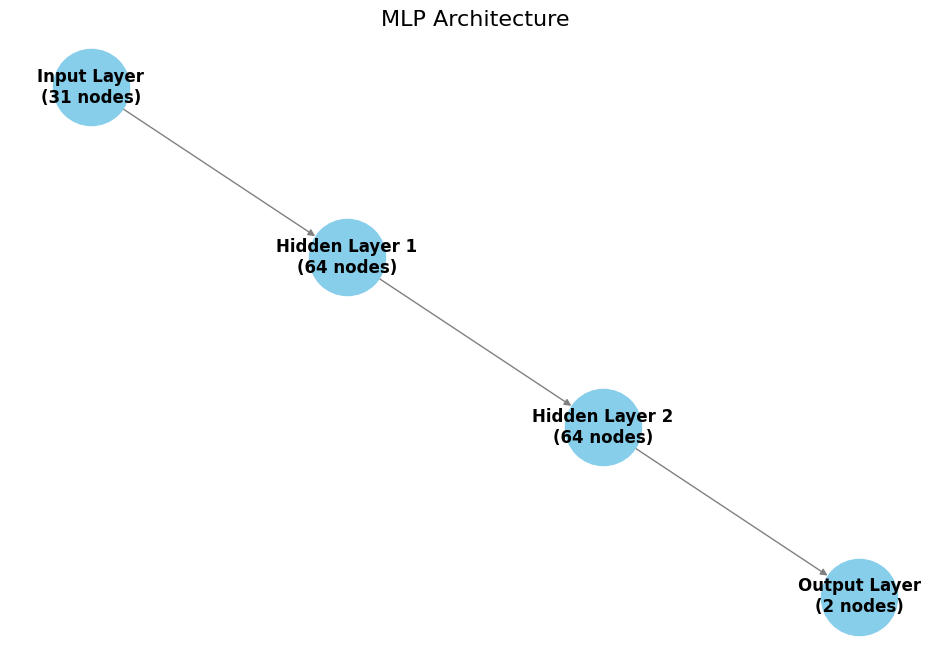

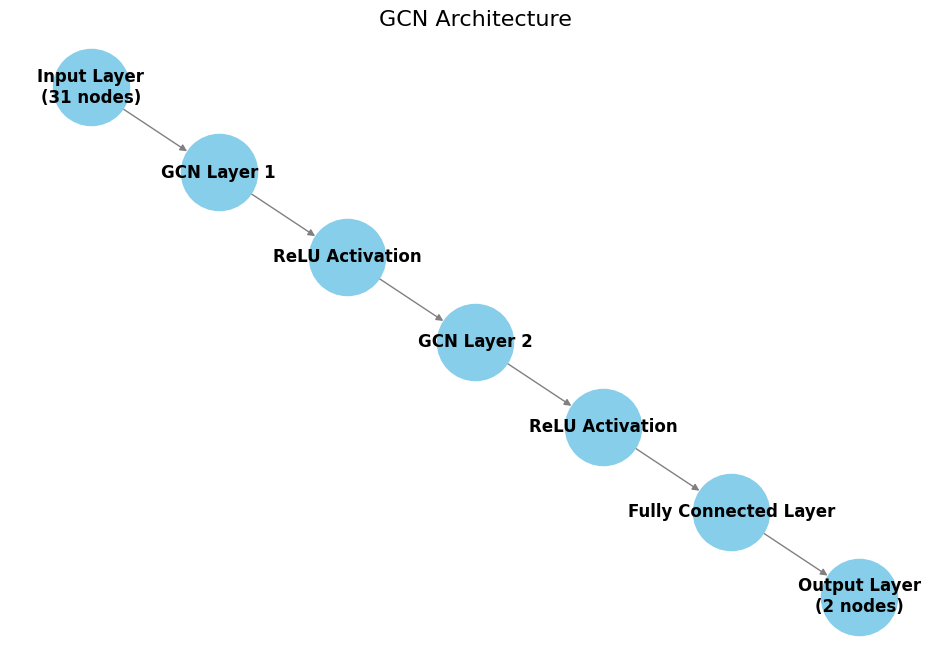

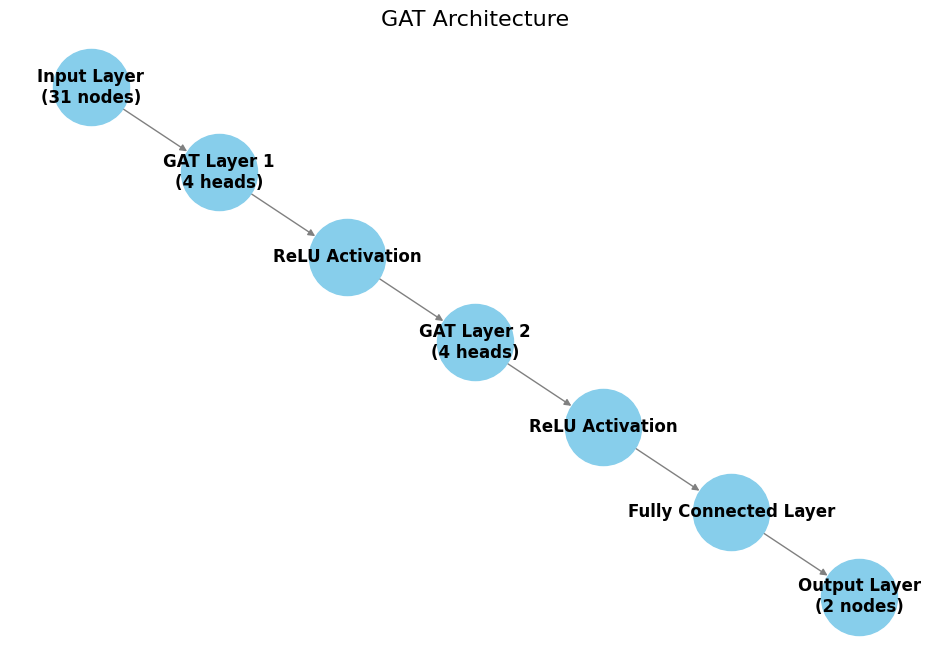

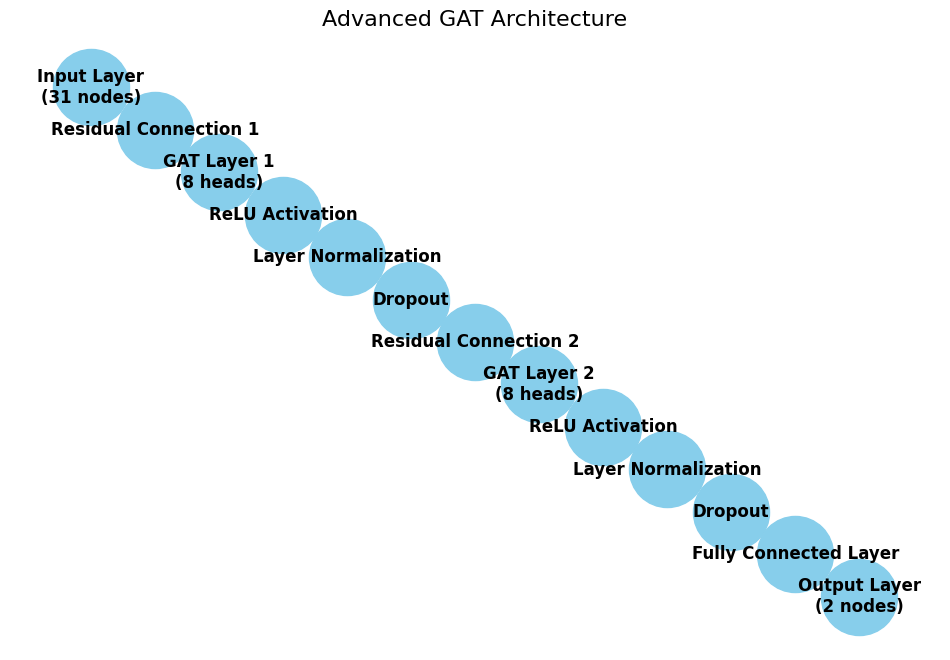

In [67]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_graph(G, pos, labels=None, title=None, node_color='skyblue', node_size=3000, edge_color='gray', font_size=12, font_color='black', font_weight='bold'):
    plt.figure(figsize=(12, 8))
    if title:
        plt.title(title, fontsize=16)
    nx.draw(G, pos, with_labels=True, labels=labels, node_color=node_color, node_size=node_size, edge_color=edge_color, font_size=font_size, font_color=font_color, font_weight=font_weight)
    plt.show()

# MLP Architecture
def visualize_mlp():
    G = nx.DiGraph()
    G.add_edges_from([('Input Layer', 'Hidden Layer 1'),
                      ('Hidden Layer 1', 'Hidden Layer 2'),
                      ('Hidden Layer 2', 'Output Layer')])
    pos = {'Input Layer': (0, 3), 'Hidden Layer 1': (1, 2), 'Hidden Layer 2': (2, 1), 'Output Layer': (3, 0)}
    labels = {'Input Layer': 'Input Layer\n(31 nodes)', 'Hidden Layer 1': 'Hidden Layer 1\n(64 nodes)',
              'Hidden Layer 2': 'Hidden Layer 2\n(64 nodes)', 'Output Layer': 'Output Layer\n(2 nodes)'}
    draw_graph(G, pos, labels, title="MLP Architecture")

# GCN Architecture
def visualize_gcn():
    G = nx.DiGraph()
    G.add_edges_from([('Input Layer', 'GCN Layer 1'),
                      ('GCN Layer 1', 'ReLU 1'),
                      ('ReLU 1', 'GCN Layer 2'),
                      ('GCN Layer 2', 'ReLU 2'),
                      ('ReLU 2', 'Fully Connected Layer'),
                      ('Fully Connected Layer', 'Output Layer')])
    pos = {'Input Layer': (0, 5), 'GCN Layer 1': (1, 4), 'ReLU 1': (2, 3), 'GCN Layer 2': (3, 2),
           'ReLU 2': (4, 1), 'Fully Connected Layer': (5, 0), 'Output Layer': (6, -1)}
    labels = {'Input Layer': 'Input Layer\n(31 nodes)', 'GCN Layer 1': 'GCN Layer 1', 'ReLU 1': 'ReLU Activation',
              'GCN Layer 2': 'GCN Layer 2', 'ReLU 2': 'ReLU Activation', 'Fully Connected Layer': 'Fully Connected Layer',
              'Output Layer': 'Output Layer\n(2 nodes)'}
    draw_graph(G, pos, labels, title="GCN Architecture")

# GAT Architecture
def visualize_gat():
    G = nx.DiGraph()
    G.add_edges_from([('Input Layer', 'GAT Layer 1'),
                      ('GAT Layer 1', 'ReLU 1'),
                      ('ReLU 1', 'GAT Layer 2'),
                      ('GAT Layer 2', 'ReLU 2'),
                      ('ReLU 2', 'Fully Connected Layer'),
                      ('Fully Connected Layer', 'Output Layer')])
    pos = {'Input Layer': (0, 5), 'GAT Layer 1': (1, 4), 'ReLU 1': (2, 3), 'GAT Layer 2': (3, 2),
           'ReLU 2': (4, 1), 'Fully Connected Layer': (5, 0), 'Output Layer': (6, -1)}
    labels = {'Input Layer': 'Input Layer\n(31 nodes)', 'GAT Layer 1': 'GAT Layer 1\n(4 heads)', 'ReLU 1': 'ReLU Activation',
              'GAT Layer 2': 'GAT Layer 2\n(4 heads)', 'ReLU 2': 'ReLU Activation', 'Fully Connected Layer': 'Fully Connected Layer',
              'Output Layer': 'Output Layer\n(2 nodes)'}
    draw_graph(G, pos, labels, title="GAT Architecture")

# Advanced GAT Architecture
def visualize_advanced_gat():
    G = nx.DiGraph()
    G.add_edges_from([('Input Layer', 'Residual Connection 1'),
                      ('Residual Connection 1', 'GAT Layer 1'),
                      ('GAT Layer 1', 'ReLU 1'),
                      ('ReLU 1', 'Layer Normalization 1'),
                      ('Layer Normalization 1', 'Dropout 1'),
                      ('Dropout 1', 'Residual Connection 2'),
                      ('Residual Connection 2', 'GAT Layer 2'),
                      ('GAT Layer 2', 'ReLU 2'),
                      ('ReLU 2', 'Layer Normalization 2'),
                      ('Layer Normalization 2', 'Dropout 2'),
                      ('Dropout 2', 'Fully Connected Layer'),
                      ('Fully Connected Layer', 'Output Layer')])
    pos = {'Input Layer': (0, 11), 'Residual Connection 1': (1, 10), 'GAT Layer 1': (2, 9), 'ReLU 1': (3, 8),
           'Layer Normalization 1': (4, 7), 'Dropout 1': (5, 6), 'Residual Connection 2': (6, 5), 'GAT Layer 2': (7, 4),
           'ReLU 2': (8, 3), 'Layer Normalization 2': (9, 2), 'Dropout 2': (10, 1), 'Fully Connected Layer': (11, 0), 'Output Layer': (12, -1)}
    labels = {'Input Layer': 'Input Layer\n(31 nodes)', 'Residual Connection 1': 'Residual Connection 1', 'GAT Layer 1': 'GAT Layer 1\n(8 heads)',
              'ReLU 1': 'ReLU Activation', 'Layer Normalization 1': 'Layer Normalization', 'Dropout 1': 'Dropout', 'Residual Connection 2': 'Residual Connection 2',
              'GAT Layer 2': 'GAT Layer 2\n(8 heads)', 'ReLU 2': 'ReLU Activation', 'Layer Normalization 2': 'Layer Normalization', 'Dropout 2': 'Dropout',
              'Fully Connected Layer': 'Fully Connected Layer', 'Output Layer': 'Output Layer\n(2 nodes)'}
    draw_graph(G, pos, labels, title="Advanced GAT Architecture")

# Visualize the model architectures
visualize_mlp()
visualize_gcn()
visualize_gat()
visualize_advanced_gat()


# Final comparison of all four models with reports and visualizations

MLP Final Accuracy: 0.8517289167964138
GCN Final Accuracy: 0.8754883341602934
GAT Final Accuracy: 0.8895808738401173
Advanced GAT Final Accuracy: 0.92614391385928
MLP Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.98      0.81     56000
           1       0.99      0.79      0.88    119341

    accuracy                           0.85    175341
   macro avg       0.84      0.89      0.84    175341
weighted avg       0.89      0.85      0.86    175341

GCN Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.97      0.83     56000
           1       0.98      0.83      0.90    119341

    accuracy                           0.88    175341
   macro avg       0.86      0.90      0.87    175341
weighted avg       0.90      0.88      0.88    175341

GAT Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.96      0.85    

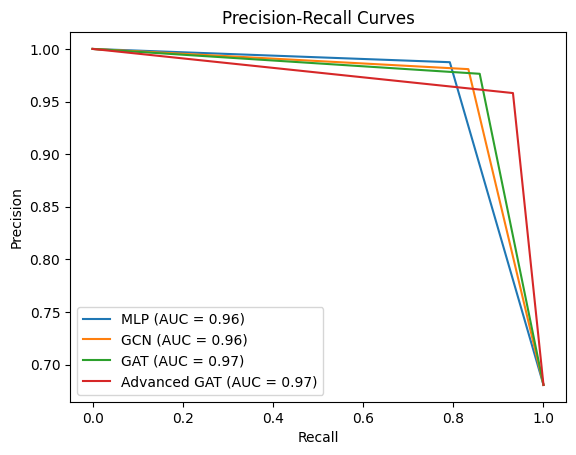

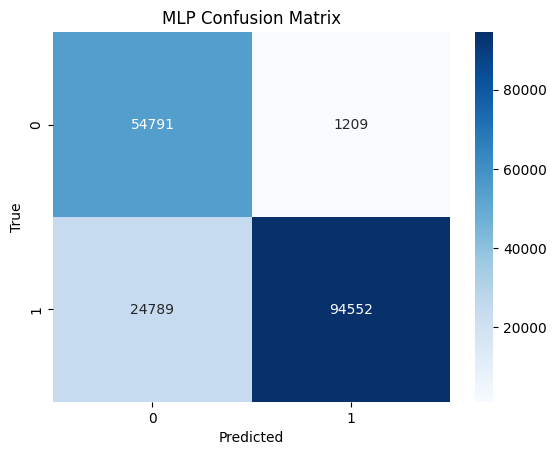

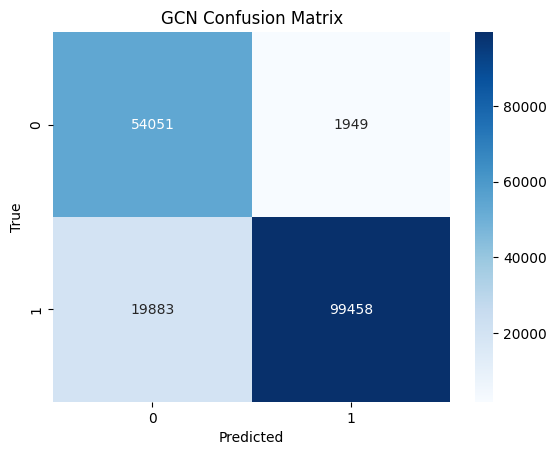

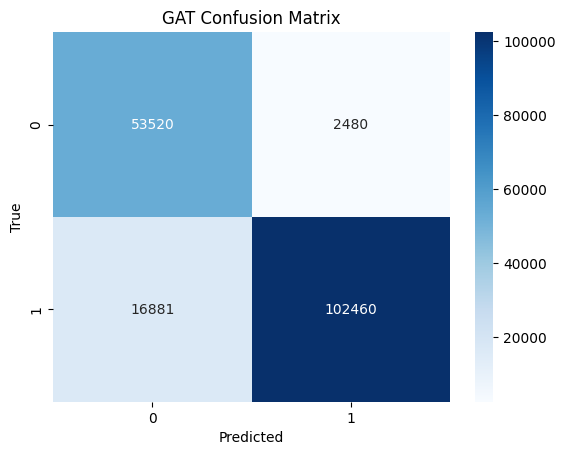

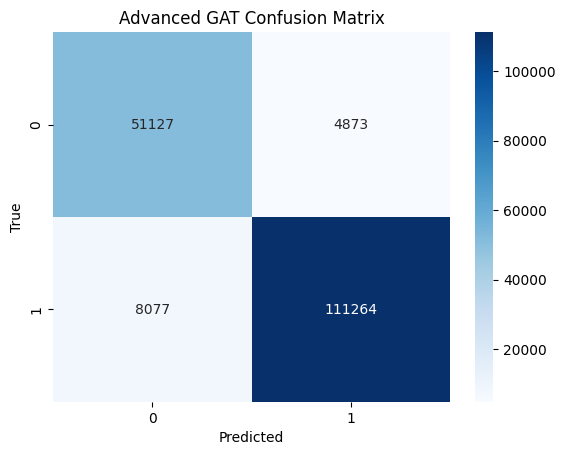

In [64]:
# Compare the models
print(f"MLP Final Accuracy: {mlp_accuracy}")
print(f"GCN Final Accuracy: {gcn_accuracy}")
print(f"GAT Final Accuracy: {accuracy}")
print(f"Advanced GAT Final Accuracy: {agat_accuracy}")

# Print Classification Reports
print("MLP Classification Report:")
print(classification_report(mlp_y_true, mlp_y_pred))

print("GCN Classification Report:")
print(classification_report(gcn_y_true, gcn_y_pred))

print("GAT Classification Report:")
print(classification_report(y_true, y_pred))

print("Advanced GAT Classification Report:")
print(classification_report(agat_y_true, agat_y_pred))

# Print Confusion Matrices
print("MLP Confusion Matrix:")
print(confusion_matrix(mlp_y_true, mlp_y_pred))

print("GCN Confusion Matrix:")
print(confusion_matrix(gcn_y_true, gcn_y_pred))

print("GAT Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("Advanced GAT Confusion Matrix:")
print(confusion_matrix(agat_y_true, agat_y_pred))

# Plot Precision-Recall Curves for all models
def plot_precision_recall_curve(y_true, y_pred, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.2f})')

plt.figure()
plot_precision_recall_curve(mlp_y_true, mlp_y_pred, 'MLP')
plot_precision_recall_curve(gcn_y_true, gcn_y_pred, 'GCN')
plot_precision_recall_curve(y_true, y_pred, 'GAT')
plot_precision_recall_curve(agat_y_true, agat_y_pred, 'Advanced GAT')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left")
plt.show()

# Plot Confusion Matrices for all models
def plot_confusion_matrix(cm, model_name):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

plot_confusion_matrix(confusion_matrix(mlp_y_true, mlp_y_pred), 'MLP')
plot_confusion_matrix(confusion_matrix(gcn_y_true, gcn_y_pred), 'GCN')
plot_confusion_matrix(confusion_matrix(y_true, y_pred), 'GAT')
plot_confusion_matrix(confusion_matrix(agat_y_true, agat_y_pred), 'Advanced GAT')

In this report, we compared the performance of various models including MLP, GCN, GAT, and an advanced GAT model on a network intrusion detection task using the UNSW-NB15 dataset. The evaluation metrics used included accuracy, precision, recall, and F1-score, along with confusion matrices and precision-recall curves to visualize the performance.

### Model Performances:

#### MLP (Multilayer Perceptron)
- **Final Accuracy**: 0.8517
- **Precision-Recall AUC**: 0.96
- **Classification Report**:
  - Precision: 0.69 (Class 0), 0.99 (Class 1)
  - Recall: 0.98 (Class 0), 0.79 (Class 1)
  - F1-Score: 0.81 (Class 0), 0.88 (Class 1)
- **Confusion Matrix**:
  - True Positives (Class 0): 54791
  - False Positives (Class 0): 1209
  - True Positives (Class 1): 94552
  - False Positives (Class 1): 24789

#### GCN (Graph Convolutional Network)
- **Final Accuracy**: 0.8755
- **Precision-Recall AUC**: 0.96
- **Classification Report**:
  - Precision: 0.73 (Class 0), 0.98 (Class 1)
  - Recall: 0.97 (Class 0), 0.83 (Class 1)
  - F1-Score: 0.83 (Class 0), 0.90 (Class 1)
- **Confusion Matrix**:
  - True Positives (Class 0): 54051
  - False Positives (Class 0): 1949
  - True Positives (Class 1): 99458
  - False Positives (Class 1): 19883

#### GAT (Graph Attention Network)
- **Final Accuracy**: 0.8896
- **Precision-Recall AUC**: 0.97
- **Classification Report**:
  - Precision: 0.76 (Class 0), 0.98 (Class 1)
  - Recall: 0.96 (Class 0), 0.86 (Class 1)
  - F1-Score: 0.85 (Class 0), 0.91 (Class 1)
- **Confusion Matrix**:
  - True Positives (Class 0): 53520
  - False Positives (Class 0): 2480
  - True Positives (Class 1): 102460
  - False Positives (Class 1): 16881

#### Advanced GAT (with Residual Connections and Layer Normalization)
- **Final Accuracy**: 0.9261
- **Precision-Recall AUC**: 0.97
- **Classification Report**:
  - Precision: 0.86 (Class 0), 0.96 (Class 1)
  - Recall: 0.91 (Class 0), 0.93 (Class 1)
  - F1-Score: 0.89 (Class 0), 0.95 (Class 1)
- **Confusion Matrix**:
  - True Positives (Class 0): 51127
  - False Positives (Class 0): 4873
  - True Positives (Class 1): 111264
  - False Positives (Class 1): 8077

### Conclusion and Insights:

#### Model Comparison:
- The Advanced GAT model outperformed all other models with a final accuracy of 0.9261 and high precision, recall, and F1-scores for both classes.
- The GCN model performed better than the MLP model, showcasing the advantage of utilizing graph-based learning for this task.
- The GAT model showed improvement over the GCN and MLP models, indicating the benefit of attention mechanisms in graph learning.

#### Performance Analysis:
- The confusion matrices and precision-recall curves reveal that the Advanced GAT model has the best performance in correctly classifying both normal and attack classes with fewer false positives and false negatives compared to other models.
- The Precision-Recall AUC values of 0.97 for both the GAT and Advanced GAT models demonstrate their effectiveness in handling imbalanced datasets by maintaining high precision and recall.
